In [1]:
import os
# 提出時は足す
# !pip install pycaret -full
# 提出時は消す
os.chdir('C:\\Users\\Takanori\\Desktop\\Kaggle\\TPS2204\\input')

# Introduction
Hey, thanks for viewing my Kernel!

If you like my work, please, leave an upvote: it will be really appreciated and it will motivate me in offering more content to the Kaggle community ! :)

EDA was done in this [notebook](https://www.kaggle.com/code/hasanbasriakcay/tpsapr22-eda-fe-baseline)</br>
Pseudo Labeling was done in this [notebook](https://www.kaggle.com/code/hasanbasriakcay/tpsapr22-fe-pseudo-labels-baseline)</br>
Prediction without NN is in this [notebook](https://www.kaggle.com/code/hasanbasriakcay/tpsapr22-optuna-lgbm-blend)

In [2]:
import pandas as pd
import numpy as np
import warnings 

warnings.simplefilter("ignore")
# indexを指定しないと、PyCaretの予測結果がめちゃくちゃになる?
train = pd.read_csv("../input/tabular-playground-series-apr-2022/train.csv")
test = pd.read_csv("../input/tabular-playground-series-apr-2022/test.csv")
train_labels = pd.read_csv("../input/tabular-playground-series-apr-2022/train_labels.csv")
sub = pd.read_csv("../input/tabular-playground-series-apr-2022/sample_submission.csv")

display(train.head())
display(test.head())
display(train_labels.head())
display(sub.head())

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,0,47,0,-0.196291,0.112395,1.0,0.329204,-1.004660,-0.131638,-0.127505,0.368702,-0.1,-0.963873,-0.985069,0.531893,4.751492
1,0,47,1,-0.447450,0.134454,1.0,-0.658407,0.162495,0.340314,-0.209472,-0.867176,0.2,-0.301301,0.082733,-0.231481,0.454390
2,0,47,2,0.326893,-0.694328,1.0,0.330088,0.473678,1.280479,-0.094718,0.535878,1.4,1.002168,0.449221,-0.586420,-4.736147
3,0,47,3,0.523184,0.751050,1.0,0.976991,-0.563287,-0.720269,0.793260,0.951145,-0.3,-0.995665,-0.434290,1.344650,0.429241
4,0,47,4,0.272025,1.074580,1.0,-0.136283,0.398579,0.044877,0.560109,-0.541985,-0.9,1.055636,0.812631,0.123457,-0.223359


,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,25968,684,0,2.427357,19.639706,1.0,-1.466372,-1.289973,-4.207928,2.486339,-2.493893,8.0,-1.123555,-1.673048,10.980453,0.419011
1,25968,684,1,-4.950541,-21.747899,1.0,0.983186,-0.569053,1.845924,-3.887978,1.727481,-2.9,0.395231,-0.882233,-1.871399,-0.008525
2,25968,684,2,1.136012,-10.756303,1.0,1.016814,0.964157,2.454749,0.312386,1.154198,-5.6,1.114162,1.525273,-11.584362,0.139812
3,25968,684,3,0.806028,6.504202,1.0,-0.179646,0.969221,-1.035153,-0.457195,0.254962,-2.7,-0.588873,0.608761,-4.241770,-0.462916
4,25968,684,4,1.288253,5.552521,1.0,-0.493805,-1.036124,-1.126402,2.008197,-0.730534,0.0,0.899566,-1.259615,-0.472222,-0.121483


,sequence,state
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1


,sequence,state
0,25968,0
1,25969,0
2,25970,0
3,25971,0
4,25972,0


In [3]:
sensors = [col for col in train.columns if 'sensor_' in col]
train_pivoted0 = train.pivot(index=['sequence', 'subject'], columns='step', values=sensors)
test_pivoted0 = test.pivot(index=['sequence', 'subject'], columns='step', values=sensors)
display(train_pivoted0.head())

sensor_00                                                    \
step                    0         1         2         3         4         5    
sequence subject                                                               
0        47      -0.196291 -0.447450  0.326893  0.523184  0.272025 -1.073416   
1        66      -6.657651  1.633694  1.863215 -2.846213  0.593509  2.469861   
2        66      -1.741886  3.402628 -0.632148  0.208655 -0.800618 -2.274343   
3        542      0.264297 -1.808346  0.078825  1.037094 -0.189335 -1.302937   
4        437      0.567233 -0.823802  1.476816 -1.710201 -0.408810  0.556414   

                                                          ... sensor_12  \
step                    6         7         8         9   ...        50   
sequence subject                                          ...             
0        47       0.350850 -0.304482 -0.216383  0.303709  ... -1.670077   
1        66      -1.202473 -0.829212  1.091190 -0.334621  ... -0.338022   
2        66       2.009274 -0.563369 -0.050232  0.800618  ... -0.172634   
3        542      1.078825  2.257342 -2.283617 -2.759660  ...  0.145354   
4        437      0.853168 -0.406491 -0.009274 -0.021638  ...  0.001705   

                                                                              \
step                    51        52        53        54        55        56   
sequence subject                                                               
0        47      -5.306479  3.621057  4.965047 -3.615090  0.791134  5.887042   
1        66       0.234868  0.030691  0.037511 -0.120205  0.056692  0.062234   
2        66       0.091645 -0.028986 -0.202472  0.332481 -0.013214  0.245524   
3        542     -0.045610 -0.098039 -0.049446  0.055840 -0.022165  0.054135   
4        437     -0.050725 -0.025149  0.106138 -0.098465 -0.040068  0.135976   

                                                  
step                    57         58         59  
sequence subject                                  
0        47      -7.211424 -26.738704 -50.658994  
1        66      -0.013640   0.098039  -0.115090  
2        66      -0.091219  -0.306905   0.046036  
3        542     -0.185422   0.311168  -0.166240  
4        437      0.121910  -0.059676  -0.087809  

[5 rows x 780 columns]

# Feature Engineering

In [4]:
from scipy.fft import rfft

In [5]:
# https://www.kaggle.com/code/ambrosm/tpsapr22-best-model-without-nn
# Feature engineering

def engineer(df):
    import scipy.stats
    new_df = pd.DataFrame([], index=df.index)
    for sensor in sensors:
        # ピボットした後のdfは、columnsを指定すると、いくつかの行をまとめて取ってこれる
        new_df[sensor + '_mean'] = df[sensor].mean(axis=1)
        new_df[sensor + '_std'] = df[sensor].std(axis=1)
        new_df[sensor + '_iqr'] = scipy.stats.iqr(df[sensor], axis=1)
        new_df[sensor + '_kurtosis'] = scipy.stats.kurtosis(df[sensor], axis=1)

        # フーリエ変換
        columns_list = [sensor + '_rfft' + str(i) for i in range(31)]
        rfftdf = pd.DataFrame(np.abs(rfft(df[sensor])), columns=columns_list)
        for column_name in columns_list:
            new_df[column_name] = rfftdf[column_name].values
    new_df['sensor_02_up'] = (df.sensor_02.diff(axis=1) > 0).sum(axis=1)
    new_df['sensor_02_down'] = (df.sensor_02.diff(axis=1) < 0).sum(axis=1)
    new_df['sensor_02_upsum'] = df.sensor_02.diff(axis=1).clip(0, None).sum(axis=1)
    new_df['sensor_02_downsum'] = df.sensor_02.diff(axis=1) .clip(None, 0).sum(axis=1)
    new_df['sensor_02_upmax'] = df.sensor_02.diff(axis=1).max(axis=1)
    new_df['sensor_02_downmax'] = df.sensor_02.diff(axis=1).min(axis=1)
    new_df['sensor_02_upmean'] = np.nan_to_num(new_df['sensor_02_upsum'] / new_df['sensor_02_up'], posinf=32)
    new_df['sensor_02_downmean'] = np.nan_to_num(new_df['sensor_02_downsum'] / new_df['sensor_02_down'], neginf=-32)
    return new_df

# sequence別に統計量を計算する
train_pivoted = engineer(train_pivoted0)
test_pivoted = engineer(test_pivoted0)

train_shuffled = train_pivoted.sample(frac=1.0, random_state=1)  # ランダムに並び替え・・・なんのために?
labels_shuffled = train_labels.reindex(train_shuffled.index.get_level_values('sequence'))
labels_shuffled = labels_shuffled[['state']].merge(train[['sequence', 'subject']].groupby('sequence').min(),
                                                   how='left', on='sequence')
labels_shuffled = labels_shuffled.merge(labels_shuffled.groupby('subject').size().rename('sequence_count'),
                                        how='left', on='subject')
train_shuffled['sequence_count_of_subject'] = labels_shuffled['sequence_count'].values

sequence_count = test_pivoted.index.to_frame(index=False).groupby('subject').size().rename('sequence_count_of_subject')
test_pivoted = test_pivoted.merge(sequence_count, how='left', on='subject')

selected_columns = train_shuffled.columns
print(len(selected_columns))
#train_shuffled.columns

464


In [6]:
train_shuffled.head()

,,sensor_00_mean,sensor_00_std,sensor_00_iqr,sensor_00_kurtosis,sensor_00_rfft0,sensor_00_rfft1,sensor_00_rfft2,sensor_00_rfft3,sensor_00_rfft4,sensor_00_rfft5,...,sensor_12_rfft30,sensor_02_up,sensor_02_down,sensor_02_upsum,sensor_02_downsum,sensor_02_upmax,sensor_02_downmax,sensor_02_upmean,sensor_02_downmean,sequence_count_of_subject
sequence,subject,,,,,,,,,,,,,,,,,,,,,
10611,242,0.001365,0.457624,0.511785,-0.263845,0.081917,0.092124,0.315373,0.151339,0.218885,0.625943,...,3.984228,10,9,1.841667,-1.841667,0.301667,-0.303333,0.184167,-0.204630,31
14656,536,-0.010484,0.949162,0.977589,2.037479,0.629057,0.845340,1.029175,0.749474,0.366593,1.026304,...,7.668798,12,11,1.826153,-1.826153,0.230000,-0.333333,0.152179,-0.166014,51
19119,245,-0.013730,1.369316,1.373068,0.982639,0.823802,0.793589,1.656657,1.875902,1.093639,4.389030,...,82.180307,8,12,1.333847,-2.000514,0.254607,-0.303801,0.166731,-0.166709,46
8143,547,0.013357,1.466844,1.906298,-0.329048,0.801391,5.907966,4.561377,5.991720,4.912017,7.757203,...,1.390878,12,18,3.526520,-3.216998,0.951628,-0.311667,0.293877,-0.178722,51
19368,120,-0.129019,1.637407,1.941267,4.630269,7.741113,7.656127,7.144146,6.209401,8.338745,8.844321,...,115.416880,12,18,3.472306,-4.102306,0.999486,-1.239486,0.289359,-0.227906,28


* PyCaretを使ってみる
* https://pycaret.gitbook.io/docs/

In [7]:
import pycaret
from pycaret.classification import *
from pycaret.classification import setup, compare_models, blend_models, finalize_model, predict_model, plot_model

In [8]:
# 予測対象であるstateをくっつける
train_df_label = pd.merge(train_shuffled, train_labels, how='left', on='sequence')

In [9]:
train_df_label.tail()

,sequence,sensor_00_mean,sensor_00_std,sensor_00_iqr,sensor_00_kurtosis,sensor_00_rfft0,sensor_00_rfft1,sensor_00_rfft2,sensor_00_rfft3,sensor_00_rfft4,sensor_00_rfft5,sensor_00_rfft6,sensor_00_rfft7,sensor_00_rfft8,sensor_00_rfft9,sensor_00_rfft10,sensor_00_rfft11,sensor_00_rfft12,sensor_00_rfft13,sensor_00_rfft14,sensor_00_rfft15,sensor_00_rfft16,sensor_00_rfft17,sensor_00_rfft18,sensor_00_rfft19,sensor_00_rfft20,sensor_00_rfft21,sensor_00_rfft22,sensor_00_rfft23,sensor_00_rfft24,sensor_00_rfft25,sensor_00_rfft26,sensor_00_rfft27,sensor_00_rfft28,sensor_00_rfft29,sensor_00_rfft30,sensor_01_mean,sensor_01_std,sensor_01_iqr,sensor_01_kurtosis,sensor_01_rfft0,sensor_01_rfft1,sensor_01_rfft2,sensor_01_rfft3,sensor_01_rfft4,sensor_01_rfft5,sensor_01_rfft6,sensor_01_rfft7,sensor_01_rfft8,sensor_01_rfft9,sensor_01_rfft10,sensor_01_rfft11,sensor_01_rfft12,sensor_01_rfft13,sensor_01_rfft14,sensor_01_rfft15,sensor_01_rfft16,sensor_01_rfft17,sensor_01_rfft18,sensor_01_rfft19,sensor_01_rfft20,sensor_01_rfft21,sensor_01_rfft22,sensor_01_rfft23,sensor_01_rfft24,sensor_01_rfft25,sensor_01_rfft26,sensor_01_rfft27,sensor_01_rfft28,sensor_01_rfft29,sensor_01_rfft30,sensor_02_mean,sensor_02_std,sensor_02_iqr,sensor_02_kurtosis,sensor_02_rfft0,sensor_02_rfft1,sensor_02_rfft2,sensor_02_rfft3,sensor_02_rfft4,sensor_02_rfft5,sensor_02_rfft6,sensor_02_rfft7,sensor_02_rfft8,sensor_02_rfft9,sensor_02_rfft10,sensor_02_rfft11,sensor_02_rfft12,sensor_02_rfft13,sensor_02_rfft14,sensor_02_rfft15,sensor_02_rfft16,sensor_02_rfft17,sensor_02_rfft18,sensor_02_rfft19,sensor_02_rfft20,sensor_02_rfft21,sensor_02_rfft22,sensor_02_rfft23,sensor_02_rfft24,sensor_02_rfft25,sensor_02_rfft26,sensor_02_rfft27,sensor_02_rfft28,sensor_02_rfft29,sensor_02_rfft30,sensor_03_mean,sensor_03_std,sensor_03_iqr,sensor_03_kurtosis,sensor_03_rfft0,sensor_03_rfft1,sensor_03_rfft2,sensor_03_rfft3,sensor_03_rfft4,sensor_03_rfft5,sensor_03_rfft6,sensor_03_rfft7,sensor_03_rfft8,sensor_03_rfft9,sensor_03_rfft10,sensor_03_rfft11,sensor_03_rfft12,sensor_03_rfft13,sensor_03_rfft14,sensor_03_rfft15,sensor_03_rfft16,sensor_03_rfft17,sensor_03_rfft18,sensor_03_rfft19,sensor_03_rfft20,sensor_03_rfft21,sensor_03_rfft22,sensor_03_rfft23,sensor_03_rfft24,sensor_03_rfft25,sensor_03_rfft26,sensor_03_rfft27,sensor_03_rfft28,sensor_03_rfft29,sensor_03_rfft30,sensor_04_mean,sensor_04_std,sensor_04_iqr,sensor_04_kurtosis,sensor_04_rfft0,sensor_04_rfft1,sensor_04_rfft2,sensor_04_rfft3,sensor_04_rfft4,sensor_04_rfft5,sensor_04_rfft6,sensor_04_rfft7,sensor_04_rfft8,sensor_04_rfft9,sensor_04_rfft10,sensor_04_rfft11,sensor_04_rfft12,sensor_04_rfft13,sensor_04_rfft14,sensor_04_rfft15,sensor_04_rfft16,sensor_04_rfft17,sensor_04_rfft18,sensor_04_rfft19,sensor_04_rfft20,sensor_04_rfft21,sensor_04_rfft22,sensor_04_rfft23,sensor_04_rfft24,sensor_04_rfft25,sensor_04_rfft26,sensor_04_rfft27,sensor_04_rfft28,sensor_04_rfft29,sensor_04_rfft30,sensor_05_mean,sensor_05_std,sensor_05_iqr,sensor_05_kurtosis,sensor_05_rfft0,sensor_05_rfft1,sensor_05_rfft2,sensor_05_rfft3,sensor_05_rfft4,sensor_05_rfft5,sensor_05_rfft6,sensor_05_rfft7,sensor_05_rfft8,sensor_05_rfft9,sensor_05_rfft10,sensor_05_rfft11,sensor_05_rfft12,sensor_05_rfft13,sensor_05_rfft14,sensor_05_rfft15,sensor_05_rfft16,sensor_05_rfft17,sensor_05_rfft18,sensor_05_rfft19,sensor_05_rfft20,sensor_05_rfft21,sensor_05_rfft22,sensor_05_rfft23,sensor_05_rfft24,sensor_05_rfft25,sensor_05_rfft26,sensor_05_rfft27,sensor_05_rfft28,sensor_05_rfft29,sensor_05_rfft30,sensor_06_mean,sensor_06_std,sensor_06_iqr,sensor_06_kurtosis,sensor_06_rfft0,sensor_06_rfft1,sensor_06_rfft2,sensor_06_rfft3,sensor_06_rfft4,sensor_06_rfft5,sensor_06_rfft6,sensor_06_rfft7,sensor_06_rfft8,sensor_06_rfft9,sensor_06_rfft10,sensor_06_rfft11,sensor_06_rfft12,sensor_06_rfft13,sensor_06_rfft14,sensor_06_rfft15,sensor_06_rfft16,sensor_06_rfft17,sensor_06_rfft18,sensor_06_rfft19,sensor_06_rfft20,sensor_06_rfft21,sensor_06_rfft22,sensor_06_rfft23,sensor_06_rfft24,sensor_06_rfft25,sensor_06_rfft26,senso

In [10]:
train_df_label.dtypes

sequence                       int64
sensor_00_mean               float64
sensor_00_std                float64
sensor_00_iqr                float64
sensor_00_kurtosis           float64
sensor_00_rfft0              float64
sensor_00_rfft1              float64
sensor_00_rfft2              float64
sensor_00_rfft3              float64
sensor_00_rfft4              float64
sensor_00_rfft5              float64
sensor_00_rfft6              float64
sensor_00_rfft7              float64
sensor_00_rfft8              float64
sensor_00_rfft9              float64
sensor_00_rfft10             float64
sensor_00_rfft11             float64
sensor_00_rfft12             float64
sensor_00_rfft13             float64
sensor_00_rfft14             float64
sensor_00_rfft15             float64
sensor_00_rfft16             float64
sensor_00_rfft17             float64
sensor_00_rfft18             float64
sensor_00_rfft19             float64
sensor_00_rfft20             float64
sensor_00_rfft21             float64
s

In [11]:
feature_selection_threshold_ = 0.3  # 0.1で25項目, 0.2で67項目

In [12]:
# https://qiita.com/tomiyou/items/e1842775e7aaee04ada3
clf1 = setup(data = train_df_label,
             target = 'state',  # 目標変数
             ignore_features =['sequence'],
             fold_strategy = 'groupkfold',
             fold_groups = 'sequence',
             use_gpu = True,
             # 1. 欠損値の処理
             imputation_type='iterative',  # 代入の方法、simple, iterative 詳細は不明
             numeric_imputation = 'mean',  # 数値データの補完方法、mean, median
             # categorical_imputation = 'constant',  # カテゴリデータの補完方法、constant, mode
             # 2. 順序データのエンコード
             # ordinal_features = { 'column_name' : ['low', 'medium', 'high'] },
             # 3. 特徴量の正規化
             normalize=True,  # 正規化を行うか否か
             # zscore->普通の正規化、minmax->[0, 1]の範囲でスケーリング、maxabs->平行移動させず、絶対値を1にする、robust->四分位を使い外れ値はそのまま残す
             normalize_method = 'robust',  # zscore, minmax, maxabs, robust
             # 4. カテゴリ変数のレア値の統合
             # combine_rare_levels = True,  # 統合を行う
             # rare_level_threshold = 0.1  # 統合を行う閾値
             # 5. 数値データのビン化
             # bin_numeric_features = ['column1', 'column2', 'column3'],  # 数値データをカテゴリ変数化させる
             # 6. 外れ値の除去
             # remove_outliers = True
             # outliers_threshold = 0.05  # 外れ値を除去する閾値
             # 7. マルチコの除去
             remove_multicollinearity = True,  # 多変量性を除外する
             # multicollinearity_threshold = 0.9
             remove_perfect_collinearity = True,  # 完全相関を除外する
             # 8. クラスタリング結果の特徴量化
             # create_clusters = True,  # 各特徴量をクラスタリングし、それを新たな特徴量として追加する
             # cluster_iter = 20,
             # 9. 統計的に有意ではない分散を持つ特徴量を削除
             # ignore_low_variance = True,
             # 10. 相互作用特徴量の生成
             # 特徴量が多いとフリーズするので注意
             # polynomial_features = True, # 多項式特徴量を作成する
             # polynomial_degree = 2,  # 多項式の次数
             # trigonometry_features = True,  # 三角関数特徴量を作成する
             # polynomial_threshold = 0.1,  # 多項式特徴量を作成する閾値　低いほど少ない
             # feature_interaction = True,  # パラメータに、変数間の積を追加する
             # feature_ratio = True,  # パラメータに、変数間の比率を追加する
             # interaction_threshold = 0.01  # 積や比率を追加する閾値
             # 11. グループ特徴量の生成
             # TODO
             # 12. 特徴量選択
             feature_selection= True, # 特徴量選択を行う。10でパラメータをかさましした時はTrue推奨
             feature_selection_threshold = feature_selection_threshold_,  # 特徴量選択後に使われるパラメータ数、大きいほどたくさん残る
             # 13. 高カーディナリィ特徴量の削減
             # 種類数が多すぎるカテゴリ変数をきれいにする
             # high_cardinality_features = ['column1', 'column2', 'column3'],
             # high_cardinality_method = 'frequency',  # frequency, clustering
             # 14. 特徴量スケーリング
             # 正規分布を仮定しして変換する。normalizeと何が違うの？
             # transformation = True,
             # transformation_method = 'yeo-johnson',  # yeo-johnson, quantile
             # 15. 目的変数のスケーリング
             # transcorm_target = True,
             # transform_target_method = 'box-cox',  # box-cox, yeo-johnson
             # 16. 特徴量の次元削減
             # pca = True,  # PCAを行い、パラメータの次元圧縮を行う
             # pca_method = 'kernel'  # 'linear', 'kernel', 'incremental'
             # pca_components = 0.99  # 残す特徴量の割合
             # 17. その他の設定
             silent = True,  # 対話的な設定を無効化
             # profile=True,  # インタラクティブなEDAレポート
             fold = 10
             )

,Description,Value
0,session_id,7721
1,Target,state
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(25968, 466)"
5,Missing Values,False
6,Numeric Features,464
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [29]:
clf1[0]

{'acc': <pycaret.containers.metrics.classification.AccuracyMetricContainer at 0x1d39ead2940>,
 'auc': <pycaret.containers.metrics.classification.ROCAUCMetricContainer at 0x1d39ead2d30>,
 'recall': <pycaret.containers.metrics.classification.RecallMetricContainer at 0x1d39ead2790>,
 'precision': <pycaret.containers.metrics.classification.PrecisionMetricContainer at 0x1d39ead2f70>,
 'f1': <pycaret.containers.metrics.classification.F1MetricContainer at 0x1d39ead20a0>,
 'kappa': <pycaret.containers.metrics.classification.KappaMetricContainer at 0x1d39ead2e50>,
 'mcc': <pycaret.containers.metrics.classification.MCCMetricContainer at 0x1d39ead2ca0>}

In [32]:
# 学習が進んできたらモデルを比較する。一旦はlightgbmでもそれなりに見れているのでこれで
# best_models = compare_models(n_select=5)
best_models = [create_model(model) for model in ['catboost', 'lightgbm', 'xgboost', 'gbc', 'rf']]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8630,0.9318,0.9103,0.8251,0.8656,0.7267,0.7303
1,0.8570,0.9291,0.8872,0.8398,0.8629,0.7137,0.7149
2,0.8553,0.9229,0.9200,0.8126,0.8629,0.7110,0.7172
3,0.8724,0.9398,0.9023,0.8607,0.8810,0.7436,0.7445
4,0.8718,0.9360,0.9264,0.8412,0.8818,0.7426,0.7467
5,0.8625,0.9281,0.9051,0.8333,0.8677,0.7250,0.7277
6,0.8570,0.9290,0.8982,0.8286,0.8620,0.7141,0.7166
7,0.8520,0.9235,0.8970,0.8190,0.8562,0.7043,0.7074
8,0.8509,0.9214,0.9107,0.8076,0.8561,0.7025,0.7079


In [33]:
tuned_models = [tune_model(i, optimize='Accuracy') for i in best_models]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8449,0.9166,0.9194,0.7933,0.8517,0.6909,0.6992
1,0.8465,0.9138,0.9067,0.8124,0.8570,0.6925,0.6974
2,0.8377,0.9105,0.9211,0.7873,0.8490,0.6760,0.6857
3,0.8625,0.9297,0.9328,0.8268,0.8766,0.7226,0.7293
4,0.8471,0.9240,0.9296,0.8044,0.8625,0.6923,0.7015
5,0.8416,0.9151,0.9183,0.7954,0.8525,0.6833,0.6916
6,0.8454,0.9132,0.9192,0.7998,0.8554,0.6911,0.6988
7,0.8316,0.9030,0.9059,0.7847,0.8410,0.6640,0.6717
8,0.8195,0.9027,0.9096,0.7645,0.8308,0.6404,0.6516


In [34]:
blender = blend_models(tuned_models)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8927,0.9559,0.9455,0.8500,0.8952,0.7860,0.7907
1,0.8856,0.9509,0.9317,0.8556,0.8920,0.7708,0.7740
2,0.8784,0.9421,0.9422,0.8338,0.8847,0.7572,0.7635
3,0.8894,0.9540,0.9370,0.8635,0.8987,0.7774,0.7806
4,0.8911,0.9565,0.9531,0.8531,0.9003,0.7811,0.7870
5,0.8828,0.9429,0.9360,0.8455,0.8884,0.7658,0.7702
6,0.8834,0.9468,0.9325,0.8481,0.8883,0.7669,0.7707
7,0.8767,0.9404,0.9362,0.8335,0.8819,0.7539,0.7594
8,0.8740,0.9407,0.9446,0.8228,0.8795,0.7487,0.7566


In [35]:
stacker = stack_models(tuned_models, meta_model=blender)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9032,0.9607,0.9421,0.8691,0.9041,0.8067,0.8094
1,0.8911,0.9577,0.9187,0.8732,0.8953,0.7820,0.7831
2,0.8872,0.9525,0.9422,0.8472,0.8922,0.7747,0.7795
3,0.8911,0.9581,0.9223,0.8762,0.8987,0.7811,0.7823
4,0.9010,0.9625,0.9499,0.8701,0.9083,0.8012,0.8048
5,0.8856,0.9469,0.9393,0.8476,0.8911,0.7713,0.7758
6,0.8889,0.9546,0.9215,0.8641,0.8919,0.7779,0.7796
7,0.8833,0.9489,0.9283,0.8485,0.8866,0.7669,0.7702
8,0.8855,0.9511,0.9480,0.8382,0.8897,0.7717,0.7780


In [36]:
best_Accuracy_model = automl(optimize = 'Accuracy')
best_Accuracy_model = calibrate_model(best_Accuracy_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9070,0.9671,0.9251,0.8878,0.9061,0.8141,0.8148
1,0.8938,0.9605,0.8980,0.8932,0.8956,0.7876,0.7876
2,0.8999,0.9550,0.9344,0.8724,0.9024,0.7999,0.8019
3,0.9015,0.9648,0.9107,0.9022,0.9064,0.8025,0.8026
4,0.8982,0.9637,0.9222,0.8854,0.9034,0.7960,0.7967
5,0.8916,0.9530,0.9227,0.8681,0.8946,0.7833,0.7849
6,0.8971,0.9602,0.9049,0.8901,0.8974,0.7943,0.7944
7,0.8866,0.9511,0.9104,0.8658,0.8876,0.7734,0.7744
8,0.8932,0.9569,0.9288,0.8625,0.8945,0.7867,0.7889


In [37]:
# best_Accuracy_model = optimize_threshold(best_Accuracy_model)

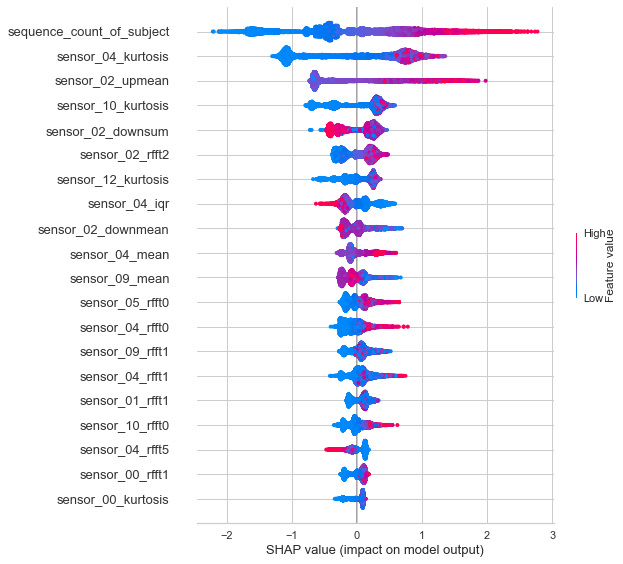

In [38]:
best_Accuracy_model = automl(optimize = 'Accuracy')
interpret_model(best_Accuracy_model)

In [39]:
final_model = finalize_model(best_Accuracy_model)  # ボールドアウトセットを含む、すべてのデータセットでトレーニングしなおす


In [40]:
best_params = final_model.get_params()

In [41]:
pred = predict_model(final_model, data=test_pivoted, raw_score=True)  # raw_score=その予測になる確率をScore二変種する

In [42]:
pred.head()

,sensor_00_mean,sensor_00_std,sensor_00_iqr,sensor_00_kurtosis,sensor_00_rfft0,sensor_00_rfft1,sensor_00_rfft2,sensor_00_rfft3,sensor_00_rfft4,sensor_00_rfft5,...,sensor_02_upsum,sensor_02_downsum,sensor_02_upmax,sensor_02_downmax,sensor_02_upmean,sensor_02_downmean,sequence_count_of_subject,Label,Score_0,Score_1
subject,,,,,,,,,,,,,,,,,,,,,
684,-0.002602,1.091741,1.078632,6.400715,0.156105,0.408389,0.118233,0.788171,0.426651,1.715250,...,0.666667,-1.332820,0.176667,-0.176667,0.166667,-0.166602,70,1,0.1093,0.8907
935,0.028516,1.450040,0.844281,6.634402,1.710974,1.742209,0.998194,1.673397,2.299503,2.678508,...,1.226502,-1.560349,0.559836,-0.228685,0.245300,-0.173372,59,1,0.0713,0.9287
924,0.057664,5.083618,6.590224,0.485832,3.459815,3.764632,4.228163,10.548077,4.164876,10.703490,...,0.333333,-0.333333,0.295000,-0.261667,0.166667,-0.166667,38,0,0.9984,0.0016
769,-0.004791,0.914917,1.034583,0.951666,0.287481,1.861962,0.886036,1.415215,1.053367,2.868641,...,0.405000,-0.071667,0.203333,-0.071667,0.135000,-0.071667,70,1,0.1999,0.8001
764,-0.001443,2.783685,0.857612,25.700057,0.086553,0.323735,2.419061,6.657667,10.187655,15.820159,...,0.570786,-0.903606,0.201356,-0.312851,0.114157,-0.150601,49,1,0.4539,0.5461


In [43]:
sub.head()

,sequence,state
0,25968,0
1,25969,0
2,25970,0
3,25971,0
4,25972,0


In [44]:
pred['Label']

subject
684    1
935    1
924    0
769    1
764    1
      ..
980    1
915    1
872    0
835    0
773    0
Name: Label, Length: 12218, dtype: int32

In [45]:
sub = pd.read_csv("../input/tabular-playground-series-apr-2022/sample_submission.csv")
sub

,sequence,state
0,25968,0
1,25969,0
2,25970,0
3,25971,0
4,25972,0
...,...,...
12213,38181,0
12214,38182,0
12215,38183,0
12216,38184,0


In [46]:
sub['state'] = pred.reset_index()['Score_1']

In [47]:
sub.to_csv('submission.csv', index=False)
sub

,sequence,state
0,25968,0.8907
1,25969,0.9287
2,25970,0.0016
3,25971,0.8001
4,25972,0.5461
...,...,...
12213,38181,0.8492
12214,38182,0.7841
12215,38183,0.3319
12216,38184,0.0088
